#### Necessary Library

In [0]:
!pip install pygsheets
!pip install --upgrade -q pygsheets
!pip install clean-text[gpl]

In [0]:
!pip install geopandas

In [0]:
# import the necessary library
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np 
import os
import ast

from datetime import datetime
import re
import string
from pprint import pprint
from cleantext import clean

import seaborn as sns
import matplotlib.pyplot as plt

import pygsheets

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 400 # this will set limit of columns to 500
pd.options.display.max_rows = 400 # this will set limit of columns to 500

# pd.options.display.max_colwidth
#pd.options.display.max_colwidth = 100
pd.options.display.max_colwidth = 200

#### Authentification Google

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Authentification with google drive and colab
from google.colab import auth
auth.authenticate_user()

# Read google sheet
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

### Data Preparation

In [0]:
!pip install python-sld

In [0]:
root_path = 'drive/My Drive/Personal Projects/2020/Nature_CASA/nature/data/'  

In [0]:
project_id = 'nature-casa'
!gcloud config set project {project_id}

Updated property [core/project].


### Step0 - Read the OSM Data

- Data source: http://download.geofabrik.de/europe/great-britain/england/greater-london.html



#### open shapefile in geopandas dataframe

In [0]:
data_path1 = 'OSM_London/gis_osm_landuse_a_free_1.shp'

In [0]:
gdf_osm = gpd.read_file(root_path+data_path1)

In [0]:
gdf_osm.head(5)

,osm_id,code,fclass,name,geometry
0,2838058,7202,park,None,"POLYGON ((-0.09186 51.66414, -0.09146 51.66418, -0.09155 51.66457, -0.09117 51.66463, -0.09124 51.66501, -0.09074 51.66507, -0.09080 51.66546, -0.09109 51.66545, -0.09113 51.66559, -0.09072 51.665..."
1,2903046,7202,park,None,"POLYGON ((-0.08025 51.66596, -0.08005 51.66690, -0.07960 51.66683, -0.07947 51.66715, -0.07917 51.66775, -0.07901 51.66790, -0.07831 51.66791, -0.07786 51.66887, -0.07714 51.66870, -0.07734 51.668..."
2,2903368,7202,park,None,"POLYGON ((-0.08663 51.66215, -0.08653 51.66293, -0.08621 51.66294, -0.08563 51.66296, -0.08565 51.66270, -0.08571 51.66225, -0.08575 51.66205, -0.08621 51.66214, -0.08663 51.66215))"
3,2903369,7202,park,None,"POLYGON ((-0.08266 51.66106, -0.08227 51.66177, -0.08060 51.66146, -0.08094 51.66077, -0.08266 51.66106))"
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07064 51.64713, -0.07058 51.64751, -0.07062 51.64866, -0.07001 51.64867, -0.07001 51.64832, -0.06909 51.64832, -0.06909 51.64887, -0.06928 51.65092, -0.06625 51.65027, -0.06572 51.647..."


##### Select only the landuse with a name! 

In [0]:
gdf_osm_name = gdf_osm[gdf_osm['name'].notnull()]
print('Number of Places with Name: '+ str(len(gdf_osm_name)))
gdf_osm_name.head(2)

Number of Places with Name: 5434


,osm_id,code,fclass,name,geometry
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07064 51.64713, -0.07058 51.64751, -0.07062 51.64866, -0.07001 51.64867, -0.07001 51.64832, -0.06909 51.64832, -0.06909 51.64887, -0.06928 51.65092, -0.06625 51.65027, -0.06572 51.647..."
5,2914274,7202,park,Stephens House & Grounds,"POLYGON ((-0.19549 51.59656, -0.19545 51.59679, -0.19539 51.59699, -0.19546 51.59700, -0.19541 51.59716, -0.19548 51.59718, -0.19544 51.59732, -0.19524 51.59790, -0.19509 51.59855, -0.19484 51.598..."


#### write gpd in geojson

In [0]:
## Transform shp into geojson
gdf_osm_name.to_crs(epsg=4326).to_file(root_path+"osm_london.geojson", driver='GeoJSON')

#### overview of gpd 

In [0]:
print('LandUse unique: '+ str(gdf_osm_name.fclass.unique()))

LandUse unique: ['park' 'forest' 'allotments' 'nature_reserve' 'retail' 'industrial'
 'scrub' 'cemetery' 'recreation_ground' 'grass' 'military' 'meadow'
 'residential' 'heath' 'farm' 'commercial' 'quarry' 'orchard']


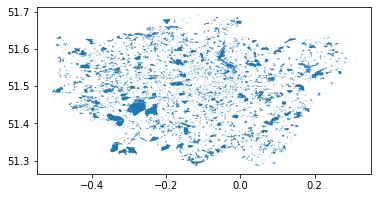

In [0]:
gdf_osm_name.plot()

In [0]:
# Add London as city name
gdf_osm_name['city'] = 'London'
gdf_osm_name.head(2)

,osm_id,code,fclass,name,geometry,city
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07064 51.64713, -0.07058 51.64751, -0.07062 51.64866, -0.07001 51.64867, -0.07001 51.64832, -0.06909 51.64832, -0.06909 51.64887, -0.06928 51.65092, -0.06625 51.65027, -0.06572 51.647...",London
5,2914274,7202,park,Stephens House & Grounds,"POLYGON ((-0.19549 51.59656, -0.19545 51.59679, -0.19539 51.59699, -0.19546 51.59700, -0.19541 51.59716, -0.19548 51.59718, -0.19544 51.59732, -0.19524 51.59790, -0.19509 51.59855, -0.19484 51.598...",London


### Step 1 - OSM Data GoogleAPI 

#### GoogleAPI Key - Get Google Adresse

In [0]:
gdf_osm_name.head(3)

,osm_id,code,fclass,name,geometry,city
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07064 51.64713, -0.07058 51.64751, -0.07062 51.64866, -0.07001 51.64867, -0.07001 51.64832, -0.06909 51.64832, -0.06909 51.64887, -0.06928 51.65092, -0.06625 51.65027, -0.06572 51.647...",London
5,2914274,7202,park,Stephens House & Grounds,"POLYGON ((-0.19549 51.59656, -0.19545 51.59679, -0.19539 51.59699, -0.19546 51.59700, -0.19541 51.59716, -0.19548 51.59718, -0.19544 51.59732, -0.19524 51.59790, -0.19509 51.59855, -0.19484 51.598...",London
6,2926821,7202,park,Oakwood Park,"POLYGON ((-0.12628 51.64196, -0.12425 51.64226, -0.12250 51.64250, -0.12189 51.64261, -0.12204 51.64303, -0.12129 51.64317, -0.12087 51.64323, -0.12062 51.64283, -0.11864 51.64311, -0.11747 51.643...",London


https://maps.googleapis.com/maps/api/place/findplacefromtext/output?parameters

In [0]:
import urllib
import requests
import json

# Google Maps API Key
API_key = 'YOUR_API_KEY'

## Request with JSON output! 
## https://developers.google.com/places/web-service/search

def Get_PlaceRating(row):
  
    try:
        url = 'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input='+str(row['name'])+','+str(row['city'])+',UK+&inputtype=textquery&fields=name,rating,user_ratings_total,price_level,place_id,formatted_address,opening_hours,types,geometry,photos&key='+str(API_key)        
        response = (requests.get(url).text)
        response_json = json.loads(response)
        return response_json  
    except Exception as error:
        raise error

#### API Response in Google Bucket

In [0]:
# run the google API
gdf_osm_name['API_response'] = gdf_osm_name.apply(Get_PlaceRating, axis=1)

# save the data into google bucket!
gdf_osm_name.to_csv('gdf_osm_name.csv')
!gsutil cp  'gdf_osm_name.csv' gs://nature-london/osm_placesapi_reponse.csv

Copying file://gdf_osm_name.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/6.6 MiB.                                      


#### GoogleAPI Key - Get Google Adresse

In [0]:
gdf_osm_name.head(1)

,osm_id,code,fclass,name,geometry,city
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07064 51.64713, -0.07058 51.64751, -0.07062 51.64866, -0.07001 51.64867, -0.07001 51.64832, -0.06909 51.64832, -0.06909 51.64887, -0.06928 51.65092, -0.06625 51.65027, -0.06572 51.647...",London


### Step 2 - Clean OSM API Response

#### Read data 

In [0]:
!gsutil cp gs://nature-london/osm_placesapi_reponse.csv osm_placesapi_reponse.csv

Copying gs://nature-london/osm_placesapi_reponse.csv...
/ [1 files][  6.6 MiB/  6.6 MiB]                                                
Operation completed over 1 objects/6.6 MiB.                                      


In [0]:
data = pd.read_csv('osm_placesapi_reponse.csv')
data = data.drop(columns='Unnamed: 0')

In [0]:
data.head(2)

,osm_id,code,fclass,name,geometry,city,API_response
0,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07063990000000001 51.6471312, -0.0705839 51.6475111, -0.0706212 51.6486592, -0.07001259999999999 51.6486665, -0.0700095 51.6483157, -0.0690897 51.648324, -0.0690914 51.64887, -0.06928...",London,"{'candidates': [{'formatted_address': 'Bush Hill Park, Enfield, UK', 'geometry': {'location': {'lat': 51.6445559, 'lng': -0.06559659999999999}, 'viewport': {'northeast': {'lat': 51.6477715, 'lng':..."
1,2914274,7202,park,Stephens House & Grounds,"POLYGON ((-0.195488 51.596565, -0.1954496 51.5967879, -0.1953905 51.5969905, -0.1954557 51.5969962, -0.1954144 51.597165, -0.1954847 51.5971776, -0.1954441 51.5973159, -0.1952418 51.5978983, -0.19...",London,"{'candidates': [{'formatted_address': '5755 N Northwood Rd, Kansas City, MO 64151, United States', 'geometry': {'location': {'lat': 39.2001643, 'lng': -94.6309606}, 'viewport': {'northeast': {'lat..."


#### Get the Ratings (Parse Json API_response)

###### step1 - get non-empty api_response

In [0]:
def Get_EmptyReponse(dataframe):
  
  api_replist = []

  for row in range(len(dataframe)): 
          # get inside the api reponse
          api_rep = ast.literal_eval(dataframe['API_response'][row])
          # check if list is empty? if yes - nan, if no - api_rep
          if len(api_rep['candidates']) == 0:
            api_rep = 'NaN'
          else:
            api_rep = api_rep['candidates']

          api_replist.append(api_rep)

  dataframe['api_rep'] = api_replist
  return dataframe

In [0]:
data = Get_EmptyReponse(data)
data.head(1)

,osm_id,code,fclass,name,geometry,city,API_response,api_rep
0,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07063990000000001 51.6471312, -0.0705839 51.6475111, -0.0706212 51.6486592, -0.07001259999999999 51.6486665, -0.0700095 51.6483157, -0.0690897 51.648324, -0.0690914 51.64887, -0.06928...",London,"{'candidates': [{'formatted_address': 'Bush Hill Park, Enfield, UK', 'geometry': {'location': {'lat': 51.6445559, 'lng': -0.06559659999999999}, 'viewport': {'northeast': {'lat': 51.6477715, 'lng':...","[{'formatted_address': 'Bush Hill Park, Enfield, UK', 'geometry': {'location': {'lat': 51.6445559, 'lng': -0.06559659999999999}, 'viewport': {'northeast': {'lat': 51.6477715, 'lng': -0.0628924}, '..."


In [0]:
data_notempty = data[data['api_rep'] != 'NaN']
print('Length of data: '+str(len(data)))
print('Length of data with an API reponse: '+str(len(data_notempty)))

Length of data: 5434
Length of data with an API reponse: 4929


In [0]:
def Parse_API_reponse(dataframe):

  apiresponse_list = []

  for row in range(len(dataframe)): 
        # get inside the api reponse
        api_rep = ast.literal_eval(dataframe['API_response'][row])
        candidates = api_rep['candidates']
        #print(candidates)
        formatted_address = api_rep['candidates'][0]['formatted_address']
        apiname = api_rep['candidates'][0]['name']
        point_location = api_rep['candidates'][0]['geometry']['location']
        place_lat = api_rep['candidates'][0]['geometry']['location']['lat']
        place_lng = api_rep['candidates'][0]['geometry']['location']['lng']
        place_id = api_rep['candidates'][0]['place_id']
        types = api_rep['candidates'][0]['types']
        try:
           rating = api_rep['candidates'][0]['rating']
           user_ratings_total =  api_rep['candidates'][0]['user_ratings_total']
        except:
           rating = 'NaN'
           user_ratings_total = 'NaN'
           
        apiresponse = [apiname,rating,user_ratings_total,point_location,place_lat,place_lng,formatted_address,place_id,types] 
        apiresponse_list.append(apiresponse)
        
  return apiresponse_list

###### step 2 - create dataframe from API parsing

In [0]:
data_notempty = data_notempty.reset_index()
data_notempty[45:48]

In [0]:
api_df = pd.DataFrame(Parse_API_reponse(data_notempty))
api_df = api_df.rename(columns={0:'apiname',1:'rating',2:'totuser_rating',3:'point_location',4:'lat',5:'lng',6:'formatted_address',7:'place_id',8:'types'})
api_df = api_df.reset_index()
api_df = api_df.rename(columns={'index':'new_index'})
api_df.head(3)

,new_index,apiname,rating,totuser_rating,point_location,lat,lng,formatted_address,place_id,types
0,0,Bush Hill Park,NaN,NaN,"{'lat': 51.6445559, 'lng': -0.06559659999999999}",51.644556,-0.065597,"Bush Hill Park, Enfield, UK",ChIJqQeM7CAfdkgR6ch-kbEcxIY,"[sublocality_level_1, sublocality, political]"
1,1,Stephens House,4.4,8,"{'lat': 39.2001643, 'lng': -94.6309606}",39.200164,-94.630961,"5755 N Northwood Rd, Kansas City, MO 64151, United States",ChIJUS-uH2_2wIcR-8SdZx7QmIs,"[point_of_interest, establishment]"
2,2,Oakwood Park,NaN,NaN,"{'lat': 51.6405629, 'lng': -0.1201883}",51.640563,-0.120188,"Oakwood Park, London, UK",ChIJ7XcjHeAYdkgRQB2qEmfr0PY,"[park, premise, point_of_interest, establishment]"


In [0]:
api_df[45:49]

###### step3 - merge OSM df with API response df

In [0]:
data_notempty = data_notempty.reset_index()
data_notempty = data_notempty.rename(columns={'level_0':'new_index'})
data_notempty[45:47]

,new_index,new_index,index,osm_id,code,fclass,name,geometry,city,API_response,api_rep
45,45,45,45,4040566,7202,park,Hendon Park,"POLYGON ((-0.2255429 51.5827476, -0.2244044 51.5828982, -0.223891 51.5829696, -0.223388 51.5831011, -0.2225126 51.5833452, -0.2219412 51.5834785, -0.2215704 51.583599, -0.2211181 51.5838227, -0.22...",London,"{'candidates': [{'formatted_address': '17 Queens Rd, Hendon, London NW4 2TL, United Kingdom', 'geometry': {'location': {'lat': 51.5826493, 'lng': -0.2217862}, 'viewport': {'northeast': {'lat': 51....","[{'formatted_address': '17 Queens Rd, Hendon, London NW4 2TL, United Kingdom', 'geometry': {'location': {'lat': 51.5826493, 'lng': -0.2217862}, 'viewport': {'northeast': {'lat': 51.58440437989272,..."
46,46,46,48,4045176,7202,park,Gladstone Park,"POLYGON ((-0.2427634 51.5594835, -0.2424191 51.559656, -0.2421978 51.5597468, -0.2417633 51.5598492, -0.2411185 51.55986, -0.240691 51.5598904, -0.2396752 51.5600374, -0.2389428 51.5601301, -0.238...",London,"{'candidates': [{'formatted_address': '52 Mulgrave Rd, London NW10 1BT, United Kingdom', 'geometry': {'location': {'lat': 51.5569348, 'lng': -0.2391632}, 'viewport': {'northeast': {'lat': 51.56245...","[{'formatted_address': '52 Mulgrave Rd, London NW10 1BT, United Kingdom', 'geometry': {'location': {'lat': 51.5569348, 'lng': -0.2391632}, 'viewport': {'northeast': {'lat': 51.5624523, 'lng': -0.2..."


In [0]:
print(len(data_notempty))
print(len(api_df))

4929
4929


In [0]:
data_merge = pd.merge(data_notempty,api_df,on='new_index')
data_merge.head(2)

,new_index,index,osm_id,code,fclass,name,geometry,city,API_response,api_rep,apiname,rating,totuser_rating,point_location,lat,lng,formatted_address,place_id,types
0,0,0,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07063990000000001 51.6471312, -0.0705839 51.6475111, -0.0706212 51.6486592, -0.07001259999999999 51.6486665, -0.0700095 51.6483157, -0.0690897 51.648324, -0.0690914 51.64887, -0.06928...",London,"{'candidates': [{'formatted_address': 'Bush Hill Park, Enfield, UK', 'geometry': {'location': {'lat': 51.6445559, 'lng': -0.06559659999999999}, 'viewport': {'northeast': {'lat': 51.6477715, 'lng':...","[{'formatted_address': 'Bush Hill Park, Enfield, UK', 'geometry': {'location': {'lat': 51.6445559, 'lng': -0.06559659999999999}, 'viewport': {'northeast': {'lat': 51.6477715, 'lng': -0.0628924}, '...",Bush Hill Park,NaN,NaN,"{'lat': 51.6445559, 'lng': -0.06559659999999999}",51.644556,-0.065597,"Bush Hill Park, Enfield, UK",ChIJqQeM7CAfdkgR6ch-kbEcxIY,"[sublocality_level_1, sublocality, political]"
1,1,1,2914274,7202,park,Stephens House & Grounds,"POLYGON ((-0.195488 51.596565, -0.1954496 51.5967879, -0.1953905 51.5969905, -0.1954557 51.5969962, -0.1954144 51.597165, -0.1954847 51.5971776, -0.1954441 51.5973159, -0.1952418 51.5978983, -0.19...",London,"{'candidates': [{'formatted_address': '5755 N Northwood Rd, Kansas City, MO 64151, United States', 'geometry': {'location': {'lat': 39.2001643, 'lng': -94.6309606}, 'viewport': {'northeast': {'lat...","[{'formatted_address': '5755 N Northwood Rd, Kansas City, MO 64151, United States', 'geometry': {'location': {'lat': 39.2001643, 'lng': -94.6309606}, 'viewport': {'northeast': {'lat': 39.201516779...",Stephens House,4.4,8,"{'lat': 39.2001643, 'lng': -94.6309606}",39.200164,-94.630961,"5755 N Northwood Rd, Kansas City, MO 64151, United States",ChIJUS-uH2_2wIcR-8SdZx7QmIs,"[point_of_interest, establishment]"


###### step 4 - Clean & Save Data into GeoJson

In [0]:
data_merge.columns

Index(['new_index', 'index', 'osm_id', 'code', 'fclass', 'name', 'geometry',
       'city', 'API_response', 'api_rep', 'apiname', 'rating',
       'totuser_rating', 'point_location', 'lat', 'lng', 'formatted_address',
       'place_id', 'types'],
      dtype='object')

In [0]:
data_merge_gpd = data_merge.loc[:,['osm_id','code','fclass','name','apiname','rating','totuser_rating','lat','lng','formatted_address','point_location','geometry']]
data_merge_gpd.head(2)

,osm_id,code,fclass,name,apiname,rating,totuser_rating,lat,lng,formatted_address,point_location,geometry
0,2903398,7202,park,Bush Hill Park,Bush Hill Park,NaN,NaN,51.644556,-0.065597,"Bush Hill Park, Enfield, UK","{'lat': 51.6445559, 'lng': -0.06559659999999999}","POLYGON ((-0.07063990000000001 51.6471312, -0.0705839 51.6475111, -0.0706212 51.6486592, -0.07001259999999999 51.6486665, -0.0700095 51.6483157, -0.0690897 51.648324, -0.0690914 51.64887, -0.06928..."
1,2914274,7202,park,Stephens House & Grounds,Stephens House,4.4,8,39.200164,-94.630961,"5755 N Northwood Rd, Kansas City, MO 64151, United States","{'lat': 39.2001643, 'lng': -94.6309606}","POLYGON ((-0.195488 51.596565, -0.1954496 51.5967879, -0.1953905 51.5969905, -0.1954557 51.5969962, -0.1954144 51.597165, -0.1954847 51.5971776, -0.1954441 51.5973159, -0.1952418 51.5978983, -0.19..."


In [0]:
data_clean_gpd = data_merge_gpd[(data_merge_gpd['lat']>51)|(data_merge_gpd['lat']<52)]
print('Number of datapoint for London: '+str(len(data_clean_gpd)))
data_clean_gpd.head(1)

Number of datapoint for London: 4929


,osm_id,code,fclass,name,apiname,rating,totuser_rating,lat,lng,formatted_address,point_location,geometry
0,2903398,7202,park,Bush Hill Park,Bush Hill Park,NaN,NaN,51.644556,-0.065597,"Bush Hill Park, Enfield, UK","{'lat': 51.6445559, 'lng': -0.06559659999999999}","POLYGON ((-0.07063990000000001 51.6471312, -0.0705839 51.6475111, -0.0706212 51.6486592, -0.07001259999999999 51.6486665, -0.0700095 51.6483157, -0.0690897 51.648324, -0.0690914 51.64887, -0.06928..."


In [0]:
type(gdf_osm)

geopandas.geodataframe.GeoDataFrame

In [0]:
## Make sure the geometry column is Polygon (and not multipolygon)!
data_clean_gpd['geometry'] = data_clean_gpd['geometry'].apply(wkt.loads)

## Transform pandas dataframe into geopandas df! 
gdf_geojson = gpd.GeoDataFrame(data_clean_gpd, geometry='geometry',crs="EPSG:4326")
type(gdf_geojson)

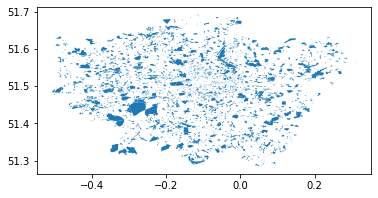

In [0]:
gdf_geojson.plot()

In [0]:
gdf_geojson.to_crs(epsg=4326).to_file(root_path+"osm_london.geojson", driver='GeoJSON')

In [0]:
gdf_geojson.head(2)

,osm_id,code,fclass,name,apiname,rating,totuser_rating,lat,lng,formatted_address,point_location,geometry
0,2903398,7202,park,Bush Hill Park,Bush Hill Park,NaN,NaN,51.644556,-0.065597,"Bush Hill Park, Enfield, UK","{'lat': 51.6445559, 'lng': -0.06559659999999999}","POLYGON ((-0.07064 51.64713, -0.07058 51.64751, -0.07062 51.64866, -0.07001 51.64867, -0.07001 51.64832, -0.06909 51.64832, -0.06909 51.64887, -0.06928 51.65092, -0.06625 51.65027, -0.06572 51.647..."
1,2914274,7202,park,Stephens House & Grounds,Stephens House,4.4,8,39.200164,-94.630961,"5755 N Northwood Rd, Kansas City, MO 64151, United States","{'lat': 39.2001643, 'lng': -94.6309606}","POLYGON ((-0.19549 51.59656, -0.19545 51.59679, -0.19539 51.59699, -0.19546 51.59700, -0.19541 51.59716, -0.19548 51.59718, -0.19544 51.59732, -0.19524 51.59790, -0.19509 51.59855, -0.19484 51.598..."
